### Main file

In [1]:
import numpy as np 
from tools.srbm import *           # !!! Importing the experimental SRBM model !!!
from tools.functions import *
import matplotlib.pyplot as plt
from brian2tools import *

date_str = str(datetime.datetime.now())[0:10]
date_time_str = str(datetime.datetime.now())[0:10]+"_"+str(datetime.datetime.now())[11:16]


/opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Some parameters for training the SRBM - the others are in paramters_main.py

t_ref = 0.004 * second
dcmt = 35
T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms

n_samples = 1000

# Loading the data
data_finnegan = load_data("data_finnegan_0.1_0.05_5_200_50")

train_test_data = train_test_split_finnegan(data_finnegan, 0.9)


prototype_class_1 = 0
sub_class_1 = 1
prototype_class_2 = 0
sub_class_2 = 0

a = train_test_data[0][prototype_class_1, sub_class_1]
b = train_test_data[0][prototype_class_2, sub_class_2]
print("Hamming distance between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_hamming_distance(a, b), 2), sep="")
print("Percent match between prototype ", str(prototype_class_1), ", ", str(sub_class_1), 
      " and prototype " , str(prototype_class_2), ", ", str(sub_class_2), " : ", round(calculate_percent_match(a, b), 2), sep="")

Data loaded from data/data_finnegan_0.1_0.05_5_200_50.npy
Hamming distance between prototype 0, 1 and prototype 0, 0 : 20.0
Percent match between prototype 0, 1 and prototype 0, 0 : 0.9


In [3]:
Ids, time_test_on, time_test_off = create_finnegan_Ids(train_test_data, off_time = 1)

In [18]:
# Create the parameters for the SRBM
W, b_v, b_c, b_h = create_rbm_parameters(N_v = N_v, N_c = N_c, N_h = N_h)

# Create timepoints for classificaiton
# One timepoint for each input pattern. Starts with timepoint 1
timepoints, t_sim, time_points_dict = create_timepoints(Ids, init_delay, delay, T)

sim_time = t_sim / (dcmt*t_ref)

In [19]:
# SRBM main function

out = main(W, b_v, b_c, b_h, Id = Ids, sim_time = sim_time, t_sim = t_sim, dorun = True, n_classes = 5, 
            monitors = True, display=False) # set display to false if no lables are used 
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']
locals().update(out)

INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_bbazycdf
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

51.432234048843384


In [20]:
# Prepare weights and biases
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta_parameter
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
mBv = np.array(Sbv.w)*beta_parameter*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta_parameter*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

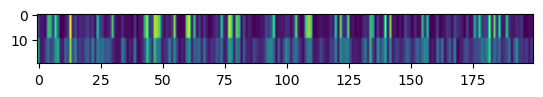

In [23]:

spike_monitor = Mv
off_time = 1

i = timepoint = 46

t_start_stimulus = time_points_dict["T"+ str(i)+"_s"]
t_stop_stimulus = time_points_dict["T"+ str(i)+"_e"]
t_start_recover = time_points_dict["T"+ str(i+1)+"_s"]
t_stop_recover = time_points_dict["T"+ str(i+off_time)+"_e"]
orig = spike_histogram(spike_monitor, t_start=t_start_stimulus, t_stop=t_stop_stimulus).T[1]
recover = spike_histogram(spike_monitor, t_start=t_start_recover, t_stop=t_stop_recover).T[1]

imshow(np.row_stack((np.repeat(orig, 10).reshape(200, 10).T, np.repeat(recover, 10).reshape(200, 10).T)))

In [24]:
# This calculates the hamming distances and percent match for all test patterns. 
# It uses the spike moitor ant the timepoints where the stimuli are presented

off_time = 1 # How many stimulus periods are used for recoverey period histogram

hamming_distances, percent_match, originals, recovered = hamming_distances_test(Mv, time_test_on, time_points_dict, off_time=off_time)

In [32]:
hamming_distances

[7500.000000000017,
 8235.714285714304,
 6700.000000000015,
 6771.428571428587,
 6642.857142857158,
 5921.428571428547,
 6349.999999999974,
 8578.571428571393,
 6892.857142857114,
 6514.2857142856865,
 6214.285714285688,
 6771.428571428543,
 6949.999999999971,
 6028.571428571404,
 6821.428571428543,
 5749.999999999976,
 5485.714285714263,
 5035.714285714264,
 5635.714285714263,
 5635.714285714263,
 5407.142857142835,
 4878.571428571408,
 5214.285714285692,
 5157.142857142836,
 5057.142857142836,
 5135.714285714264,
 5464.285714285692,
 5357.142857142835,
 5292.85714285712,
 5585.714285714263,
 5049.999999999979,
 4699.99999999998,
 5192.857142857121,
 5114.285714285693,
 5278.571428571407,
 4714.285714285695,
 4642.857142857123,
 5242.857142857121,
 4707.142857142837,
 4985.714285714264,
 4307.142857142839,
 4757.142857142838,
 5414.285714285692,
 4707.142857142837,
 4964.285714285694,
 5021.428571428551,
 5078.5714285714075,
 5264.285714285692,
 5321.428571428549,
 5678.571428571405]

In [31]:
hd_table

array([[7500.        , 8235.71428571, 6700.        , 6771.42857143,
        6642.85714286, 5921.42857143, 6350.        , 8578.57142857,
        6892.85714286, 6514.28571429],
       [6214.28571429, 6771.42857143, 6950.        , 6028.57142857,
        6821.42857143, 5750.        , 5485.71428571, 5035.71428571,
        5635.71428571, 5635.71428571],
       [5407.14285714, 4878.57142857, 5214.28571429, 5157.14285714,
        5057.14285714, 5135.71428571, 5464.28571429, 5357.14285714,
        5292.85714286, 5585.71428571],
       [5050.        , 4700.        , 5192.85714286, 5114.28571429,
        5278.57142857, 4714.28571429, 4642.85714286, 5242.85714286,
        4707.14285714, 4985.71428571],
       [4307.14285714, 4757.14285714, 5414.28571429, 4707.14285714,
        4964.28571429, 5021.42857143, 5078.57142857, 5264.28571429,
        5321.42857143, 5678.57142857]])

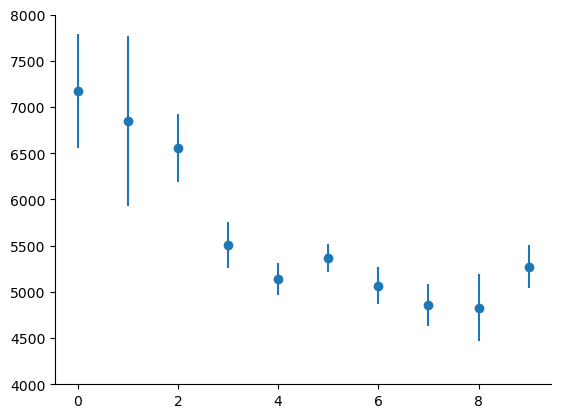

7010.71428571428

In [37]:
hd_table = np.array(hamming_distances).reshape(10, 5)
means = np.mean(hd_table, axis=1)
stds = np.std(hd_table, axis=1)

fig, ax = plt.subplots()
ax.errorbar(np.arange(10), means, stds, linestyle='None', marker='o')
ax.set_ylim([4000, 8000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

mean(hamming_distances[:10])